In [1]:
import os
import math
import wandb
import torch
import pandas as pd
import torch.nn as nn

import straug.blur as blur
import straug.warp as warp
import straug.noise as noise
import straug.camera as camera
import straug.process as process
import straug.geometry as geometry

from PIL import Image
from tabulate import tabulate
from tqdm.notebook import tqdm
from pytorch_lightning import seed_everything
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchmetrics import CharErrorRate, WordErrorRate

seed_everything(1, True)
DEVICE = 'cuda:0'

Global seed set to 1


# Что из себя представляют данные

Сами изображения в двух папках, а их метки в файлах tcv:

In [2]:
os.listdir('./dataset/')

['test', 'test.tsv', 'train', 'train.tsv']

# Посмотрим на различия алфавита:

In [3]:
test_df = pd.read_csv('./dataset/test.tsv', delimiter='\t', names = ['Image name', 'Label'])
test_alphabet = set(test_df['Label'].to_string())

train_df = pd.read_csv('./dataset/train.tsv', delimiter='\t', names = ['Image name', 'Label'])
train_alphabet = set(train_df['Label'].to_string()) - set('\n')
train_alphabet.difference(test_alphabet)

{'!', '"', '%', "'", '+', ';', '<', '=', '>', '?', '[', ']', 'Ц', 'Щ', '№'}

Эта функция нужна для поиска некорректных меток и их редактирования. `set('«»')` - пример некорректных символов, для каждого нежелательного символа можно посмотреть файл, где он содержится и убрать/заменить его. Для каждого неккоректого лейбла в тренировочном наборе вручную исправим все недостатки.

In [4]:
for i in range(len(train_df['Image name'])):
    try:
        if len(set('«»') - set(train_df.iloc[i][1])) != len(set('«»')):
            print(train_df.iloc[i][0])
    except Exception:
        print(i)

После выполнения функции можно увидеть, что на некоторых картинках не хватает разметки. Дополним эту разметку

Также в данных были и ошибочные метки - ссылка, из-за которой добавлялись английские символы, сокращенный знак кавычек >> или <<. Все эти шумы отфильтровались или заменились на корректные символы

# Dataset class

In [5]:
class HWTDataset(Dataset):
    """
    Class for creating custom image2label dataset from folder

    Args:
        Dataset (Dataset): Standart torch class for custom datasets
    """
    
    
    def __init__(self, root_dir: str, label_dir: str, transforms = None):
        
        super(HWTDataset, self).__init__()
        
        name_label = pd.read_csv(label_dir, delimiter='\t', names = ['Image name', 'Label'])
        name_label['Image name'] = name_label['Image name'].apply(lambda x: os.path.join(root_dir, x))
        self.data = name_label.to_dict('split')['data']
        
        self.transforms = transforms
    
    
    def __len__(self):
        return len(self.data)
    
        
    def __getitem__(self, index: int):
        
        path, label = self.data[index]
        img = Image.open(path).convert('RGB')
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        if img.shape[0] == 1:
            img = img.expand((3, -1, -1))
        
        return img, label

# Decoder class

In [6]:
class SymbolCoder:
    """
    Class needs to encode initial text to Tensor
    and decode predicted labels to text
    """
    
    def __init__(self, alphabet) -> None:
        
        self.alphabet = alphabet
        self.sym2class, self.class2sym = {'' : 0}, {0 : ''}
        
        for num, alpha in enumerate(sorted(alphabet)):
            self.sym2class[alpha] = num + 1
            self.class2sym[num + 1] = alpha
    
    
    def encode(self, text):
        """
        This method needs for encoding initial word to Tensor

        Args:
            text (str): Initial text for encode

        Returns:
            tuple: First value is a tensor of word(s) classes, second is length(s) of word(s)
        """
        
        length = []
        result = []
        
        for word in text:
            length.append(len(word))
            for alpha in word:
                if alpha in self.alphabet: 
                    result.append(self.sym2class[alpha])
                else: result.append(0)
        
        return (torch.LongTensor(result), torch.LongTensor(length))
    
    
    def decode(self, text, length):
        """
        This method used for decoding prediction classes to text

        Args:
            text (Tensor): predicted text(s)
            length (Tensor): length(s) of prediction text(s)

        Returns:
            str or list: list type returns when use for batch, for single word returns str
        """
        
        #For single word
        if length.numel() == 1:
            
            length = length[0]
            word = ''
            
            for i in range(length):
                if text[i] != 0 and not (i > 0 and text[i - 1] == text[i]):
                    word  += self.class2sym[text[i].item()]
            return word
        
        #For batch
        else:
            
            words = []
            index = 0
            
            for i in range(length.numel()):
                l = length[i]
                words.append(
                    self.decode(text[index:index + l], torch.IntTensor([l])))
                index += l
            return words
    
    
    def __len__(self):
        return len(self.class2sym)

# Augmentations

In [7]:
train_transform = transforms.Compose([
    #transforms.RandomApply([transforms.RandomChoice([warp.Stretch(), warp.Curve(), warp.Distort(), geometry.Rotate()])], 0.5),
    #transforms.RandomApply([transforms.GaussianBlur((3, 3))], 0.3),
    #transforms.RandomApply([noise.GaussianNoise()], 0.3),
    #transforms.ColorJitter(0.1, 0.5, 0.3, 0.3),
    #transforms.RandomApply([warp.Curve()], 0.3),
    transforms.RandomApply([transforms.Grayscale(1)], 1),
    transforms.Resize((64, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

test_transform = transforms.Compose([
    #transforms.RandomApply([transforms.RandomChoice([warp.Stretch(), warp.Curve(), warp.Distort(), geometry.Rotate()])], 0.5),
    #transforms.RandomApply([transforms.GaussianBlur((3, 3))], 0.3),
    #transforms.RandomApply([noise.GaussianNoise()], 0.3),
    #transforms.ColorJitter(0.1, 0.5, 0.3, 0.3),
    #transforms.RandomApply([warp.Curve()], 0.3),
    transforms.RandomApply([transforms.Grayscale(1)], 1),
    transforms.Resize((64, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load data

In [8]:
train_data = HWTDataset('./dataset/train/', './dataset/train.tsv', train_transform)
test_data = HWTDataset('./dataset/test/', './dataset/test.tsv', test_transform)

# Model 1

In [9]:
class RNN1(nn.Module):
    """
    This class use for seq 2 seq prediction
    """
    
    def __init__(self, in_len, out_len, n_classes = None,
                 bidirectional = True, batch_first = True) -> None:
        
        super(RNN1, self).__init__()
        self.n_classes = n_classes
        self.linear = None
        
        self.rnn = nn.RNN(in_len, out_len, 
                          bidirectional = bidirectional, 
                          batch_first = batch_first)
        
        if self.n_classes:
            self.linear = nn.Linear(out_len * [1, 2][bidirectional], n_classes)

    
    def forward(self, data):
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        N, L, H_in = data.shape
        
        data, _ = self.rnn(data) # [N, L, [1, 2] * n_hidden], 1 if bidir = False, else 2
        if self.linear:
            data = data.reshape(N * L, -1)
            data = self.linear(data)
            data = data.reshape(N, L, -1)
        
        return data

In [10]:
class Model1(nn.Module):
    """
    This class use for slicing initial image
    """
    
    def __init__(self, len_alphabet) -> None:
        super(Model1, self).__init__()
        
        # In - 3x64x224
        self.layer_1 = nn.Sequential()
        self.layer_1.add_module('1', nn.Conv2d(3, 8, 3))
        self.layer_1.add_module('act', nn.ReLU())
        self.layer_1.add_module('2', nn.MaxPool2d(2, (2, 1), 1))
        self.layer_1.add_module('3', nn.BatchNorm2d(8))
        # Out - 8x32x224
        
        # In - 8x32x224
        self.layer_2 = nn.Sequential()
        self.layer_2.add_module('1', nn.Conv2d(8, 64, 3))
        self.layer_2.add_module('act', nn.ReLU())
        self.layer_2.add_module('2', nn.MaxPool2d(2, 2, 1))
        self.layer_2.add_module('3', nn.BatchNorm2d(64))
        # Out - 64x16x224
        
        # In - 64x16x112
        self.layer_3 = nn.Sequential()
        self.layer_3.add_module('1', nn.Conv2d(64, 256, 3))
        self.layer_3.add_module('act', nn.ReLU())
        self.layer_3.add_module('2', nn.MaxPool2d(2, 2))
        self.layer_3.add_module('3', nn.BatchNorm2d(256))
        # Out - 256x8x56
        
        # In - 256x8x56
        self.layer_4 = nn.Sequential()
        self.layer_4.add_module('1', nn.Conv2d(256, 512, 3))
        self.layer_4.add_module('act', nn.ReLU())
        self.layer_4.add_module('2', nn.MaxPool2d(2, 2))
        self.layer_4.add_module('3', nn.BatchNorm2d(512))
        # Out - 512x2x28

        self.rnn_layers = nn.Sequential(
            RNN1(2*512, 256, bidirectional=True, batch_first=True),
            RNN1(512, 256, len_alphabet + 1, bidirectional=True, batch_first=True)
        )
        
    
    def forward(self, data):
        data = self.layer_1(data)
        data = self.layer_2(data)
        data = self.layer_3(data)
        data = self.layer_4(data)
        # bs, c, h, w
        
        bs, c, h, w = data.shape
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        data = data.permute(0, 3, 1, 2).reshape(bs, w, c * h) # bs, w, h * c equal to N, L, H
        data = self.rnn_layers(data) # N, L, len_alphabet
        data = data.permute(1, 0, 2) # L, N, len_alphabet
        
        prob = torch.nn.functional.log_softmax(data, 2)
        
        return prob

# Model 2

In [11]:
class RNN2(nn.Module):
    """
    This class use for seq 2 seq prediction
    """
    
    def __init__(self, in_len, out_len, n_classes = None,
                 bidirectional = True, batch_first = True) -> None:
        
        super(RNN2, self).__init__()
        self.n_classes = n_classes
        self.linear = None
        
        self.rnn = nn.RNN(in_len, out_len, 
                          bidirectional = bidirectional, 
                          batch_first = batch_first)
        
        if self.n_classes:
            self.linear = nn.Linear(out_len * [1, 2][bidirectional], n_classes)

    
    def forward(self, data):
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        N, L, H_in = data.shape
        
        data, _ = self.rnn(data) # [N, L, [1, 2] * n_hidden], 1 if bidir = False, else 2
        if self.linear:
            data = data.reshape(N * L, -1)
            data = self.linear(data)
            data = data.reshape(N, L, -1)
        
        return data

In [12]:
class Model2(nn.Module):
    """
    This class use for slicing initial image
    """
    
    def __init__(self, len_alphabet) -> None:
        super(Model2, self).__init__()
        
        # In - 3x64x224
        self.layer_1 = nn.Sequential()
        self.layer_1.add_module('1', nn.Conv2d(3, 64, 3, padding=1))
        self.layer_1.add_module('2', nn.BatchNorm2d(64))
        self.layer_1.add_module('3', nn.LeakyReLU())
        # Out - 8x32x224
        
        # In - 8x32x224
        self.layer_2 = nn.Sequential()
        self.layer_2.add_module('1', nn.Conv2d(64, 128, 3, padding=1))
        self.layer_2.add_module('2', nn.BatchNorm2d(128))
        self.layer_2.add_module('3', nn.LeakyReLU())
        self.layer_2.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 64x16x224
        
        # In - 64x16x112
        self.layer_3 = nn.Sequential()
        self.layer_3.add_module('1', nn.Conv2d(128, 256, 3, padding=1))
        self.layer_3.add_module('2', nn.BatchNorm2d(256))
        self.layer_3.add_module('3', nn.LeakyReLU())
        # Out - 256x8x56
        
        # In - 64x16x112
        self.layer_4 = nn.Sequential()
        self.layer_4.add_module('1', nn.Conv2d(256, 256, 3, padding=1))
        self.layer_4.add_module('2', nn.BatchNorm2d(256))
        self.layer_4.add_module('3', nn.LeakyReLU())
        self.layer_4.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 256x8x56
        
        # In - 256x8x56
        self.layer_5 = nn.Sequential()
        self.layer_5.add_module('1', nn.Conv2d(256, 512, 3, padding=1))
        self.layer_5.add_module('2', nn.BatchNorm2d(512))
        self.layer_5.add_module('3', nn.LeakyReLU())
        # Out - 512x2x28
        
        # In - 256x8x56
        self.layer_6 = nn.Sequential()
        self.layer_6.add_module('1', nn.Conv2d(512, 512, 3, padding=1))
        self.layer_6.add_module('2', nn.BatchNorm2d(512))
        self.layer_6.add_module('3', nn.LeakyReLU())
        self.layer_6.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 512x2x28
        
        # In - 256x8x56
        self.layer_7 = nn.Sequential()
        self.layer_7.add_module('1', nn.Conv2d(512, 512, 3, padding=1))
        self.layer_7.add_module('2', nn.BatchNorm2d(512))
        self.layer_7.add_module('3', nn.LeakyReLU())
        # Out - 512x2x28

        self.rnn_layers = nn.Sequential(
            RNN2(8*512, 512, bidirectional=True, batch_first=True),
            RNN2(2*512, 128, len_alphabet + 1, bidirectional=True, batch_first=True)
        )
        
    
    def forward(self, data):
        data = self.layer_1(data)
        data = self.layer_2(data)
        data = self.layer_3(data)
        data = self.layer_4(data)
        data = self.layer_5(data)
        data = self.layer_6(data)
        data = self.layer_7(data)
        # bs, c, h, w
        
        bs, c, h, w = data.shape
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        data = data.permute(0, 3, 1, 2).reshape(bs, w, c * h) # bs, w, h * c equal to N, L, H
        data = self.rnn_layers(data) # N, L, len_alphabet
        data = data.permute(1, 0, 2) # L, N, len_alphabet
        
        prob = torch.nn.functional.log_softmax(data, 2)
        
        return prob

# Pretty info output

In [13]:
def print_epoch_data(epoch, mean_loss, char_error, word_error, zero_out_losses):
    
    print(tabulate([['epoch', 'mean loss', 'mean cer', 'mean wer', 'zero loss warnings'],
                    [epoch, round(mean_loss, 4), round(char_error, 4),
                    round(word_error, 4), zero_out_losses]],
                   headers='firstrow', tablefmt='fancy_grid'))

# Train functions

### Saving model and logging statistics

In [14]:
def print_save_stat(outputs, epoch, model, scheduler, model_name, zero_out):
    
    if len(outputs) == 0:
        print('ERROR: bad loss')
        raise Exception
        
    output = torch.Tensor(outputs)
    mean_loss = output[:, 0].mean()
    char_error = output[:, 1].mean()
    word_error = output[:, 2].mean()
    print_epoch_data(epoch, mean_loss.item(), char_error.item(), word_error.item(), zero_out)
    
    wandb.log({'loss': mean_loss.item(),
               'CER': char_error.item(),
               'WER': word_error.item(),
               'Learn Rate': scheduler.get_last_lr()[-1]})
    
    if char_error < 0.1:
        torch.save(model.state_dict(), f'./{model_name}_L-{round(mean_loss.item(), 4)}_CER-{round(char_error.item(), 4)}.pth')

### Train

In [15]:
def train(model, optimizer, scheduler, dataloader, lossfunc, epochs, model_name):
    
    model.train()
    wandb.watch(model, lossfunc, log='all', log_freq=100)
    coder = SymbolCoder(train_alphabet)
    CER = CharErrorRate()
    WER = WordErrorRate()
    
    for epoch in tqdm(range(epochs), total=epochs):
        
        zero_out_losses = 0
        outputs = []
        
        for batch_nb, (data, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
            
            optimizer.zero_grad()
            
            classes, lengths = coder.encode(targets)
            
            data = data.to(DEVICE)
            classes = classes.to(DEVICE)
            length = lengths.to(DEVICE)
            
            logits = model(data)
            logits = logits.contiguous().cpu()
            T, N, C = logits.size()
            pred_sizes = torch.LongTensor([T for i in range(N)]).to(DEVICE)
            classes = classes.view(-1).contiguous()
            loss = lossfunc(logits, classes, pred_sizes, lengths)
            
            if (torch.zeros(loss.size()) == loss).all():
                zero_out_losses += 1
                continue
            
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = coder.decode(preds.data, pred_sizes.data)
            
            cer = CER(sim_preds, targets)
            wer = WER(sim_preds, targets)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            output = [abs(loss.item()), cer, wer]
            outputs.append(output)
        
        print_save_stat(outputs, epoch, model, scheduler, model_name, zero_out_losses)

# Config

### Wandb

In [16]:
wandb.init(
    project="Handwritten text recognition",
    config={
        "Model type": 'Model 2',
        "architecture": "RCNN",
        "dataset": "Handwritten Cyrillic dataset",
        "epochs": 30,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kozlovmihail02. Use `wandb login --relogin` to force relogin


### Model

In [16]:
ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)
model = Model2(len(train_alphabet))
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
dataloader = DataLoader(train_data, 8, True) # Если ставить батч 16, то лосс не падает
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)

In [ ]:
wandb.init(
    id='35odcpyv',
    project="Handwritten text recognition",
    resume='must'
)

In [ ]:
train(model, optimizer, scheduler, dataloader, ctc_loss, 20, 'M2_T1')

# Prediction stage

### Word correction based on external dictionary

In [81]:
def word_correction(predictions):
    
    import enchant
    
    CER = CharErrorRate()
    correct_predictions = []
    dictionary = enchant.Dict("ru_RU")
    
    for word in tqdm(predictions, total=len(predictions)):

        words = word.split()
        result = ''

        for word in words:
            if word.isalpha():
                
                sim = dict()
                
                if dictionary.check(word):
                    result += word + ' '
                    continue
                
                suggestions = set(dictionary.suggest(word))

                for suggest in suggestions:
                    if ' ' not in suggest:
                        measure = CER(suggest, word)
                        sim[measure] = suggest
                if len(sim.keys()) > 0: 
                    result += sim[min(sim.keys())] + ' '
                    continue
            result += word + ' '

        correct_predictions.append(result[:-1])
    return correct_predictions

### Counting statistics about incorrect symbol predictoin

In [76]:
def errors_sym_stat(preds, targets):
    
    sym_er = {}
    
    for pred, true in zip(preds, targets):
        if len(true) == len(pred) and true != pred:
            for i, j in zip(pred, true):
                if i != j: 
                    if j in sym_er.keys(): 
                        if i in sym_er[j].keys():
                            sym_er[j][i] += 1
                        else: sym_er[j][i] = 1
                    else: sym_er[j] = {i : 1}
    return sym_er

### Model eval

In [77]:
def evaluate(model, correcting = False, count_err_stat = False):
    
    model = model.eval()
    CER = CharErrorRate()
    WER = WordErrorRate()
    coder = SymbolCoder(train_alphabet)
    loader = torch.utils.data.DataLoader(test_data, batch_size = 8)
    labels, predictions = [], []
    
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch[0].to(DEVICE), batch[1]
        labels.extend(targets)
        logits = model(input_)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = coder.decode(pos.data, pred_sizes.data)
        predictions.extend(sim_preds)
    
    if correcting: predictions = word_correction(predictions)
    
    char_error = CER(predictions, labels)
    word_error = WER(predictions, labels)
    print({'char_error' : char_error, 'word_error' : word_error})
    
    if count_err_stat: return errors_sym_stat(predictions, labels)

In [20]:
model.load_state_dict(torch.load('./M2_T1_L-0.0489_CER-0.0141.pth'))

<All keys matched successfully>

Обычный тест, без коррекции слов

In [21]:
evaluate(model)

  0%|          | 0/193 [00:00<?, ?it/s]

{'char_error': tensor(0.2045), 'word_error': tensor(0.6889)}


С проверкой орфографии слов

In [22]:
evaluate(model, correcting=True)

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/1544 [00:00<?, ?it/s]

{'char_error': tensor(0.2196), 'word_error': tensor(0.5647)}


Видно, что CER немного поднялся, однако качество определения слов возросло на 12%

Посмотрим какие символы чаще путает наша модель. На основе этой статистики возможно реализовать замену вероятных ошибочных символов и искать ближайшее совпадение в словаре (с учетом того, что в нашем тексте нет требований к сохранению четкой орфографии писавшего человека)

In [23]:
a = evaluate(model, count_err_stat=True)

similar_sym = {}
for true_sym in a:
    for pred_sym in a[true_sym]:
        if a[true_sym][pred_sym] >= 10:
            if pred_sym in similar_sym.keys(): 
                similar_sym[pred_sym].update({true_sym : a[true_sym][pred_sym]})
            else: similar_sym[pred_sym] = {true_sym : a[true_sym][pred_sym]}
similar_sym

  0%|          | 0/193 [00:00<?, ?it/s]

{'char_error': tensor(0.2045), 'word_error': tensor(0.6889)}


{'я': {'е': 11},
 'и': {'е': 14, 'н': 35},
 'с': {'е': 14},
 'г': {'ч': 11},
 'н': {'к': 20, 'м': 11},
 'о': {'а': 24},
 'е': {'и': 17, 'с': 25},
 'к': {'н': 17},
 'а': {'о': 16},
 'л': {'м': 14}}

In [24]:
def predict(model, img, correcting = False):
    
    CER = CharErrorRate()
    coder = SymbolCoder(train_alphabet)
    
    logits = model(img.to(DEVICE))
    logits = logits.contiguous().cpu()
    T, B, H = logits.size()
    pred_sizes = torch.LongTensor([T for i in range(B)])
    probs, pos = logits.max(2)
    pos = pos.transpose(1, 0).contiguous().view(-1)
    predictions = coder.decode(pos.data, pred_sizes.data)
    
    if correcting: predictions = word_correction(predictions)
        
    return predictions

In [25]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 9)

  0%|          | 0/9 [00:00<?, ?it/s]

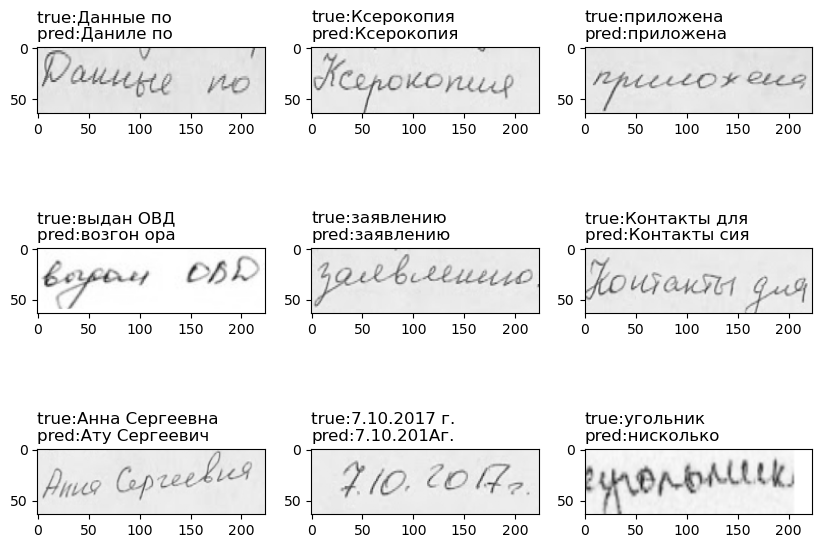

In [82]:
import matplotlib.pyplot as plt

examples = []
idx = 0
coder = SymbolCoder(train_alphabet)

for n, batch in enumerate(test_loader):
    if n <= 2: continue
    img, true_label = batch[0], batch[1]
    pred_label = predict(model, img, True)
    examples = [img, true_label, pred_label]
    break
fig = plt.figure(figsize=(10, 10))
rows = int(9 / 4) + 2
columns = int(9 / 8) + 2
for j in range(len(examples[-1])):
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(examples[0][j].permute(1, 2, 0) * 0.5 + 0.5) #denormalize data
    plt.title('true:' + examples[1][j] + '\npred:' + examples[2][j], loc = 'left')

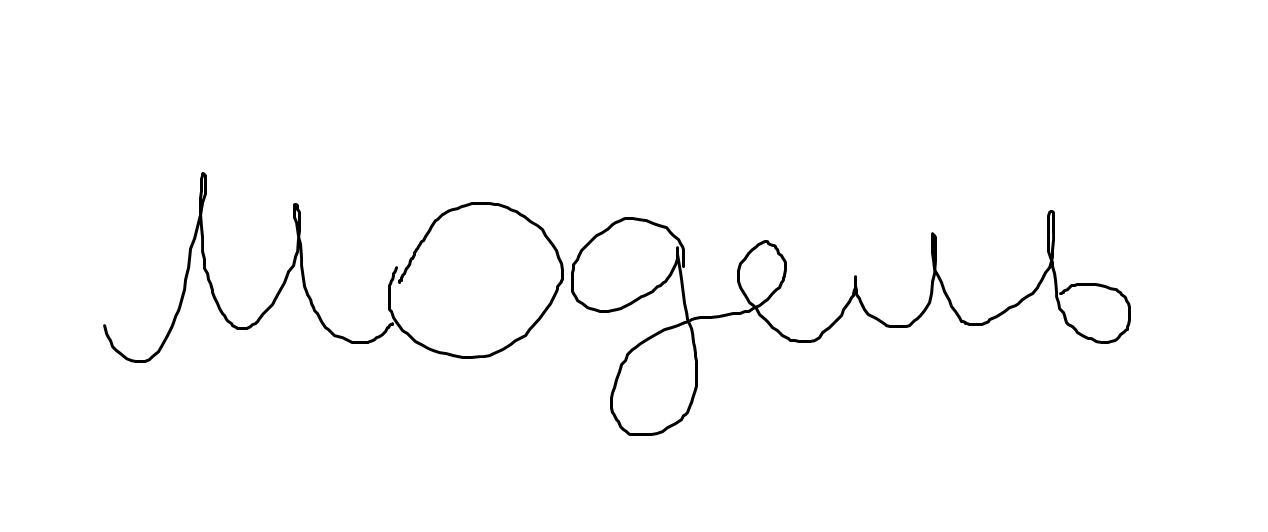

'модель'

In [74]:
from IPython.display import display

img2 = Image.open('./Модель.png')
display(img2)
img2 = test_transform(img2)

logits = model(img2.expand(3, -1, -1).unsqueeze(0).to(DEVICE))
logits = logits.contiguous().cpu()
T, B, H = logits.size()
pred_sizes = torch.LongTensor([T])
probs, pos = logits.max(2)
pos = pos.transpose(1, 0).contiguous().view(-1)
predictions = coder.decode(pos.data, pred_sizes.data)
predictions